## 3. Seq2Seq Machine Translation with Attention

---

In this problem we will implement a neural network that translates sentences from French to English. This is made possible by the simple but powerful idea of the sequence to sequence network, in which two recurrent neural networks work together to transform one sequence to another. In its vanilla version, an encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence. To improve upon this model, we’ll use an attention mechanism, which lets the decoder learn to focus over a specific range of the input sequence. <br/>
The architecture of our network is inspired by (but not exactly similar to) the neural machine translation model proposed by [1].

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import List, Dict
from pprint import pprint
import unicodedata
from itertools import chain
from collections import Counter
import random
import json
import re
import time
import math

### 3.1 Downloading and Reading the Data




The data for this problem is a set of many thousands of English to French translation pairs. First let's download the data.

In [2]:
! wget https://download.pytorch.org/tutorial/data.zip
! unzip -q data.zip

--2023-10-12 21:25:07--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.138.94.103, 108.138.94.65, 108.138.94.113, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.138.94.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  6.18MB/s    in 0.4s    

2023-10-12 21:25:08 (6.18 MB/s) - ‘data.zip’ saved [2882130/2882130]



Here is a sneak peek at our dataset:

In [3]:
DATA_PATH = 'data/eng-fra.txt'
! head -n 10 $DATA_PATH

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


As you can see, every line contains a sentence in English and its translated version in French (Sentences are sorted by their length, so the first few sentences are very short).

In [4]:
# Setting the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Feel free to use the following variables wherever you like throughout the notebook
START_TOKEN = '<START>'
END_TOKEN = '<END>'
PAD_TOKEN = '<PAD>'

PAD_IDX = 0
START_IDX = 1
END_IDX = 2


# Function for setting the random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if DEVICE == torch.device("cuda"):
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.cuda.empty_cache()

cuda


Let's define some functions to read the data from file and preprocess it.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def read_corpus(path):
    """Reads the corpus from the file.

    path: corpus file's path
    """
    print("Reading the corpus...")

    # Read the file and split into lines
    lines = open(path, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    src_sents = [s[1].split() for s in pairs]
    # Marking the beginning and end of target sentences with <START> and <END>
    tgt_sents = [[START_TOKEN] + s[0].split() + [END_TOKEN] for s in pairs]

    return src_sents, tgt_sents

Let's read the corpus and print a couple of sentences of it:

In [6]:
src_sents, tgt_sents = read_corpus(DATA_PATH)
pprint(src_sents[:5])
pprint(tgt_sents[:5])

print('\nNumber of sentences', len(src_sents))

Reading the corpus...
[['va', '!'],
 ['cours', '!'],
 ['courez', '!'],
 ['ca', 'alors', '!'],
 ['au', 'feu', '!']]
[['<START>', 'go', '.', '<END>'],
 ['<START>', 'run', '!', '<END>'],
 ['<START>', 'run', '!', '<END>'],
 ['<START>', 'wow', '!', '<END>'],
 ['<START>', 'fire', '!', '<END>']]

Number of sentences 135842


### 3.2 Vocabulary

As we need the Vocab class you implemented in Problem 1 here, copy your implementaion in the following cell (or copy your code into a .py file and import it from there).

In [7]:
class Vocab:
    def __init__(self, word2id=None):
        """Constructor of Vocab

        word2id: dictionary that maps tokens to their ids.
        """
        self.pad_token = '<PAD>'
        self.end_token = '<END>'
        self.start_token = '<START>'
        self.unk_token = '<UNK>'

        if word2id is None:
            self.word2id = {self.pad_token: 0,
                            self.start_token: 1,
                            self.end_token: 2,
                            self.unk_token: 3}
            self.size = 4
        else:
            self.word2id = word2id
            self.size = len(self.word2id)

        self.id2word = {v: k for (k, v) in self.word2id.items()}

    def build(self, tokenized_corpus: List[List[str]], size=None, min_freq=None):
        """Builds the vocab from a tokenized corpus.

        tokenized_corpus: corpus as a list of list of tokens (strings)
        size: Final size of (number of unique tokens in) our vocab
        min_freq: minimum frequency
        """
        tokens2freq = Counter(chain(*tokenized_corpus))  # dict that maps unique tokens to their freqs in the corpus
        frequent_tokens = []

        if size == None or min_freq == None:
          frequent_tokens = tokenized_corpus
        else:
          frequent_tokens = [x for x in tokenized_corpus if counter[x] > min_freq ]
        if not (size == None):
          if size > len (frequent_tokens) :
            frequent_tokens =  frequent_tokens[0:size]
        pass

        for token in frequent_tokens:
            self.add_token(token)

    def get_token_by_id(self, t_id: int) -> str:
        """Returns the token with the corresponding id in the vocab.
        If the id is not valid, returns None.

        t_id: token id
        """
        return self.id2word.get(t_id, None)

    def get_id_by_token(self, token: str) -> int:
        """Returns the id of the token in the vocab. If the token does not exist,
        returns the id of <UNK> token.

        token: token (as a string) for which the id should be returned.
        """
        return self.word2id.get(token, self.word2id[self.unk_token])

    def add_token(self, token: str):
        """Adds the token to the vocab's data structures
        token: token as a string
        """

        for t in token:
          if t not in self.word2id:
            self.word2id[t] = self.size
            self.id2word[self.size] = t
            self.size += 1

        pass


    def tokens2ids(self, sents):
        """Convert list of words or list of sentences of tokens
        into list or list of list of indices.

        sents: input sentences as List[List[str]] (multiple sentences) or List[str]
        (single sentence)
        """

        if type(sents[0]) == list:
            output_sents = [[self.get_id_by_token(x) for x in line] for line in sents]
        else:
            output_sents = [self.get_id_by_token(x) for x in sents]
            pass
        return (output_sents)


    def to_tensor(self, sent: List[str]):
        """Converts a sentence as a list of tokens into a tensor of indices.

        sent: a sentence as a list of strings (tokens)
        """

        my_list = self.tokens2ids(sent)
        tensor_out = torch.tensor(my_list , dtype = torch.long , device = DEVICE)
        return tensor_out
        pass


    def pad_sents(self, sents: List[List[str]]) -> List[List[str]]:
        """Pads list of sentences according to the longest sentence.

        sents: sentences as a list of list of tokens (strings).
        """
        sents_padded = []

        sents_padded = sents
        max_len = max(len(l) for l in sents)
        for l in range (len(sents)):
          for i in range (max_len - len(sents[l])):
            sents_padded[l].append (self.pad_token)

        pass

        return sents_padded

    def save(self, path: str):
        """Saves the vocab in a json file.

        path: path to save the vocab in
        """
        with open(path, 'w') as f:
            json.dump(self.word2id, f)

    @staticmethod
    def load(path: str):
        """Loads vocab from a json file.

        path: path to load the vocab from
        """
        with open(path, 'r') as f:
            word2id = json.load(f)

        return Vocab(word2id)

Now let's create the vocabs using our source and target sentences:

In [8]:
src_vocab = Vocab()
src_vocab.build(src_sents)
tgt_vocab = Vocab()
tgt_vocab.build(tgt_sents)

# You could also set the size of the vocab and minimum frequency of the words if you'd like
print('French Vocab Size:', src_vocab.size)
print('English Vocab Size:', tgt_vocab.size)

French Vocab Size: 21335
English Vocab Size: 13044


### 3.3 Creating Dataset and DataLoader

Now Let's create datasets and dataloaders so that we can later use them for training our model:

In [9]:
class NMTData(Dataset):
    def __init__(self, src_sents: List[List[str]], tgt_sents: List[List[str]], transform):
        self.src_sents = src_sents
        self.tgt_sents = tgt_sents
        self.transform = transform

    def __len__(self):
        return len(self.src_sents)

    def __getitem__(self, item):
        sents = {'src': self.src_sents[item], 'tgt': self.tgt_sents[item]}
        return self.transform(sents)


# utility function for padding a tensor
def pad_tensor(tensor: torch.Tensor, size: int, dim: int=-1):
    """
    tensor: tensor to pad
    size: the size to pad to
    dim: dimension to pad

    returns a new tensor padded to 'size' in dimension 'dim'
    """
    pad_size = list(tensor.shape)
    pad_size[dim] = size - tensor.size(dim)
    pad = torch.full(pad_size, PAD_IDX, dtype=tensor.dtype, device=tensor.device)

    return torch.cat([tensor, pad], dim=dim)


# Thanks to https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8
class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """
    def __init__(self, dim=-1):
        """
        dim: the dimension to be padded (e.g., dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        """
        batch: a batch of data as a list of Dictionaries

        returns:
          src_sents: tensor of source sentences
          tgt_sents: tensor of target sentences
          src_lengths: lengths of source sentences before padding as a list
        """

        # sort pairs based on the lengths of source sentences
        batch = sorted(batch, key=lambda pair: pair['src'].size(0), reverse=True)
        src_lengths = [pair['src'].size(0) for pair in batch]

        # find longest sequence
        max_len_src = max(map(lambda pair: pair['src'].shape[self.dim], batch))
        max_len_tgt = max(map(lambda pair: pair['tgt'].shape[self.dim], batch))

        # pad according to max_len
        batch = list(map(lambda pair: (pad_tensor(pair['src'], size=max_len_src, dim=self.dim),
                                       pad_tensor(pair['tgt'], size=max_len_tgt, dim=self.dim)),
                         batch))

        # stack all
        src_sents = torch.stack([pair[0] for pair in batch], dim=-1)
        tgt_sents = torch.stack([pair[1] for pair in batch], dim=-1)

        return src_sents, tgt_sents, src_lengths

    def __call__(self, batch):
        return self.pad_collate(batch)


class ToTensor(object):
    """A callable transform that converts sentences to Tensors.
    """
    def __init__(self, src_vocab: Vocab, tgt_vocab: Vocab):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __call__(self, sents: Dict):
        src_sent, tgt_sent = sents['src'], sents['tgt']

        return {'src': self.src_vocab.to_tensor(src_sent),
                'tgt': self.tgt_vocab.to_tensor(tgt_sent)}


Now let's create a sample dataloader and read a batch of data:

In [10]:
set_seed(40719)
dataset = NMTData(src_sents=src_sents, tgt_sents=tgt_sents,
                  transform=ToTensor(src_vocab, tgt_vocab))
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0,
                        collate_fn=PadCollate())

src_sents_tensor, tgt_sents_tensor, src_lengths = next(iter(dataloader))
print(src_sents_tensor, tgt_sents_tensor, src_lengths, sep='\n\n')

tensor([[   23,    23,   116,    73,    23],
        [  264,  1081, 16253,   247,   261],
        [   53,    12,  1891,    12,    13],
        [  250,  1258,   725,  5135,  2095],
        [ 2141,  3159,   830,   133,    16],
        [  232,    12, 16254,  2283,     0],
        [ 2142,   122,    16,    16,     0],
        [ 4475,   338,     0,     0,     0],
        [   16,    16,     0,     0,     0]], device='cuda:0')

tensor([[   1,    1,    1,    1,    1],
        [  14,   14,  525,   62,   14],
        [  24,   35, 9513,  349,   68],
        [ 439, 3470,  352,   30, 1357],
        [2419,  202,  374,   96,  525],
        [ 334,   22, 3123,  130, 1968],
        [2472, 1689, 4831,    5,    5],
        [   5,  202,    5,    2,    2],
        [   2, 1694,    2,    0,    0],
        [   0,  170,    0,    0,    0],
        [   0,    5,    0,    0,    0],
        [   0,    2,    0,    0,    0]], device='cuda:0')

[9, 9, 7, 7, 5]


Now we are ready to code our Seq2Seq model.

### 3.4 Seq2Seq with Attention Model

In Machine Translation, our goal is to convert a sentence from the source language to the target language. In this assignment, we will implement a sequence-to-sequence (Seq2Seq) network with attention, to build a Neural Machine Translation (NMT) system. In this section, we describe the training procedure for the proposed NMT system:

1. Given a sentence in the source language, we look up the word embeddings from the source embeddings matrix with the embedding dimension $e$.

2. We feed these embeddings to the Encoder, yielding hidden states $h_{0}^{enc},...,h_{m}^{enc} \in \mathbb{R}^h$ where $h$ is the *hidden size* of the network and $m$ is the length of the source sequence.

3. We then initialize the Decoder's first hidden state $h_0^{dec} \in \mathbb{R}^h$ by applying a linear projection (called *bridge*) on the Encoder's final hidden state.

4. With the Decoder initialized, we must now feed it the matching sentence in the target language. On the $t$-th step, we look up the embedding for the $t$-th word (or token), $y_t \in \mathbb{R}^e$ where $e$ is the *embedding size*. Note that during the training procedure where we use teacher forcing, $y_t$ is the $t$-th word in the target sentence. However, in the test stage where we do not have a target sentence, the output word of the model at the previous time step will be used as $y_t$.

5. We then concatenate $y_t$ with the combined-output vector from the previous timestep (the gray vector in the illustration below which is denoted by $\tilde{h}$) to produce $\hat{y}_{t} \in \mathbb{R}^{e+h}$. for the first target word (i.e. the start token), previous combined-output vector is a zero-vector. We then feed $\hat{y}_{t}$ as input to the decoder.

6. We use $h_t^{dec}$ to compute **dot attention** over $h_{0}^{enc},...,h_{m}^{enc}$ (please refer to the paper for the details about this type of attention). This will give us a combination of the Encoder's hidden states called the *context vector* (blue vector in the illustration).

7. We concatenate the context vector with the decoder hidden state $h_{t}^{dec}$ at each step and apply a linear layer (called *attn_combine* in the code), Tanh, and Dropout to get the next combined-output vector.

8. After doing the above procedure for all of the time steps (i.e. generating the combined outputs of all time steps), we will apply the target vocab projection layer to compute scores (logits) of producing different words in the target vocab at all of the time steps simultaneously.

9. We then produce the log-probability **$P$**, using log-softmax function, over target words and sum the log probability of generating the correct word over all of the time steps. We then minimize negative value of this sum to train our network.


The above algorithm will become clearer to you as we walk through their implementation step by step later.

The following figure from the paper illustrates the attention mechanism we will implement. Note that without attention mechanism, the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some $h$ dimensional space of sentences. This vector will then be passed to the decoder to generate the desired output. This single vector carries the burden of encoding the entire sentence. But, with attention, the decoder network can “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs.

<p align="center">
<img src="https://i.imgur.com/RUmR1CU.png" height=400/>
</p>

Here is another illustration of the training procedure of our Seq2Seq model. Note that this figure shows stacked (multi-layer) RNNs as the Encoder and the Decoder. We will use a single layer rnn in our implementation. Note that `<s>` and `</s>` are START and END tokens [4].


<p align="center">
<img src="https://imgur.com/download/Xf46eg0" height=400/>
</p>

Let's start coding the model. Here is the code of our encoder's class.

In [11]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, embed_size: int, src_vocab_size: int):
        """
        hidden_size: hidden size to be used for the RNN
        embed_size: embedding size (dimension)
        src_vocab_size: source language vocab's size
        """
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.src_vocab_size = src_vocab_size
        self.rnn = nn.GRU(input_size= self.embed_size , hidden_size= self.hidden_size)
        self.src_embedding = nn.Embedding(num_embeddings= self.src_vocab_size , embedding_dim= self.embed_size , padding_idx= PAD_IDX)

        pass


    def forward(self, src: torch.Tensor, src_lengths: List[int]):
        """
        src: tensor of source sentences containing token's indices in the vocab
        src_lengths: lengths of source sentences before padding
        """
        enc_hiddens, last_hidden, enc_hiddens_mask = None, None, None
        #1
        embed_out = self.src_embedding(src)
        #2
        enc_hiddens , last_hidden = self.rnn(pack(embed_out , lengths= src_lengths))
        enc_hiddens , lengths = unpack(enc_hiddens)
        #3
        enc_hiddens = enc_hiddens.permute(1 , 0 , 2)
        #4
        enc_hiddens_mask = self.generate_enc_hiddens_mask(enc_hiddens , lengths)
        pass

        return enc_hiddens, last_hidden, enc_hiddens_mask

    def generate_enc_hiddens_mask(self, enc_hiddens: torch.Tensor, lengths: List[int]) -> torch.Tensor:
        """Generates mask which masks the encoder hidden states corresponding to <PAD> tokens
        in the source sentences
        """
        enc_masks = torch.zeros(enc_hiddens.shape[0], enc_hiddens.size(1), dtype=torch.float)
        for iterator, length in enumerate(lengths):
            enc_masks[iterator, length:] = 1

        return enc_masks.to(DEVICE)

Here is the code of our decoder's class:

In [12]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size: int, embed_size: int, tgt_vocab_size: int, dropout_rate=0.2):
        """
        hidden_size: hidden size to be used for the RNN
        embed_size: embedding size (dimension)
        tgt_vocab_size: target language vocab size
        dropout_rate: rate to be used for the dropout layer
        """
        super(AttnDecoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.tgt_vocab_size = tgt_vocab_size
        self.tgt_embedding = nn.Embedding(num_embeddings= self.tgt_vocab_size ,embedding_dim= self.embed_size
                                          , padding_idx= PAD_IDX)
        self.rnn = nn.GRUCell(self.embed_size + self.hidden_size  , self.hidden_size)
        self.attn_combine = nn.Linear(2 *self.hidden_size , self.hidden_size , bias= False)
        self.tgt_vocab_projection = nn.Linear(self.hidden_size , self.tgt_vocab_size , bias= False)
        self.dropout = nn.Dropout(dropout_rate)


        pass


    def forward(self, enc_hiddens: torch.Tensor, enc_hiddens_mask: torch.Tensor,
                dec_init_state: torch.Tensor, tgt: torch.Tensor):
        """Runs the teacher forcing algorithm and returns the scores (logits) of different words
        across all of the time steps. The logits shape should be (seq_len_tgt-1, batch_size, tgt_vocab_size).

        tgt: tensor of target sentences with shape (seq_len_tgt, batch_size)
        enc_hiddens: tensor of the encoder hidden states with shape (batch_size, seq_len_src, hidden_size)
        enc_hiddens_mask: tensor of the encoder hidden states with shape (batch_size, seq_len_src)
        dec_init_state: decoder's initial hidden state
        """
        # remove the <END> token from the longest sentence(s)
        tgt = tgt[:-1]

        # Initialize the decoder state
        dec_state = dec_init_state

        # Initialize previous combined output vector as zero
        batch_size = enc_hiddens.size(0)
        combined_output_prev = torch.zeros(batch_size, self.hidden_size, device=DEVICE )
        # Initialize a list we will use to collect the combined output o_t at each step
        combined_outputs = []
        logits = None

        embed_out = self.tgt_embedding(tgt)
        #2
        for i in range (embed_out.shape[0] ):
          step_input = torch.cat((embed_out[i] , combined_output_prev) , 1)
          dec_state , combined_output = self.step(step_input , dec_state , enc_hiddens , enc_hiddens_mask)
          combined_outputs.append(combined_output)
          combined_output_prev = combined_output
        #3
        combined_outputs = torch.stack(combined_outputs)
        #4
        logits = self.tgt_vocab_projection(combined_outputs)

        pass

        return logits

    def step(self, ybar_t: torch.Tensor, dec_state: torch.Tensor, enc_hiddens: torch.Tensor, enc_hiddens_mask):
        """
        ybar_t: the input to be fed to the decoder at the current step with shape
        dec_state: decodor's previous hidden state
        enc_hiddens: encoder hidden states (outputs)
        enc_hiddens_mask: mask generated during the encoding phase that masks <PAD>s

        returns the current hidden state and combined output
        """
        attn_scores_t, dec_state_t = None, None

        #1
        dec_state_t = self.rnn(ybar_t , dec_state)
        #2
        temp_dec = dec_state_t.reshape(dec_state_t.shape[0]  , dec_state_t.shape[1]  , 1 )
        attn_scores_t = torch.bmm(enc_hiddens , temp_dec)
        attn_scores_t = attn_scores_t.squeeze(2)
        pass


        # Set attn_scores_t to -inf where enc_hiddens_mask has 1, where there is a <PAD>
        # in the source sentence.
        if enc_hiddens_mask is not None:
            attn_scores_t.data.masked_fill_(enc_hiddens_mask.bool(), -float('inf'))

        combined_output_t = None

        #1
        weights = F.softmax(attn_scores_t , 1)
        #2
        weights = weights.reshape(weights.shape[0]  ,1, weights.shape[1]  )
        contex_vector = torch.bmm(weights , enc_hiddens )
        #3
        contex_vector = contex_vector.squeeze(1)
        contex_vector = torch.cat(( dec_state_t , contex_vector ) , 1)
        combined_output_t = self.attn_combine(contex_vector)
        #4
        combined_output_t = torch.tanh(combined_output_t)
        combined_output_t = self.dropout(combined_output_t)
        pass

        return dec_state_t, combined_output_t

The following class is the whole Sequence-to-Sequence model.

In [13]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, hidden_size: int, embed_size: int, src_vocab_size: int,
                 tgt_vocab_size: int, dropout_rate:float=0.2):
        """
        hidden_size: hidden size (dimensionality) of the RNNs
        embed_size: embedding size (dimensionality)
        src_vocab_size: source sentences Vocabulary object
        tgt_vocab_size: target sentences Vocabulary object
        dropout_rate: dropout probability
        """
        super(AttnSeq2Seq, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.src_vocab_size, self.tgt_vocab_size = src_vocab_size, tgt_vocab_size
        self.dropout_rate = dropout_rate
        self.encoder, self.decoder, self.bridge = None, None, None

        self.encoder = Encoder(self.hidden_size , self.embed_size , self.src_vocab_size)
        self.bridge = nn.Linear(self.hidden_size , self.hidden_size , bias = False)
        self.decoder = AttnDecoder(self.hidden_size , self.embed_size , self.tgt_vocab_size , self.dropout_rate)
        pass


    def init_weights(self, val: float):

        for p in self.parameters():
          nn.init.uniform_(p , a= -val , b= val)
        pass


    def forward(self, src_tensor: torch.Tensor, tgt_tensor: torch.Tensor, src_lengths: List[int]):
        """ Takes a mini-batch of source and target sentences, compute the log-likelihood of
        target sentences under the language models learned by the neural machine translation
        system.

        src_tensor: tensor of source sentences
        tgt: tensor of target sentences
        src_lengths: lengths of source sentences before padding
        """
        log_probs = None

        #1
        enc_outputs , enc_hidden , enc_hidden_mask = self.encoder(src_tensor , src_lengths)
        #2
        enc_hidden = enc_hidden.squeeze(0)
        init_hidden = self.bridge(enc_hidden)
        #3
        logits = self.decoder(enc_outputs , enc_hidden_mask , init_hidden , tgt_tensor)
        #4
        log_probs = F.log_softmax(logits , -1)
        pass

        tgt_mask = (tgt_tensor != PAD_IDX).float()

        # Compute log probability of generating true target words
        tgt_gold_words_log_prob = torch.gather(log_probs, index=tgt_tensor[1:].unsqueeze(-1), dim=-1).squeeze(-1) * tgt_mask[1:]
        # sum scores across different time steps of sequences (i.e. computing log probability of the sequences)
        scores = tgt_gold_words_log_prob.sum(dim=0)

        return scores
    def greedy_decode(self, src_sent: torch.Tensor, tgt_vocab: Vocab, max_length: int = 50):
        """
        src_sent: source sentence tensor with shape (seq_len, 1)
        max_length: allowed maximum length of the target translation

        returns decoded_sent: decoded translation of source sentence
        """
        decoded_sent = []

        enc_outputs , enc_hidden , enc_hidden_mask = self.encoder(src_sent , [len(src_sent)])
        #not so sure about this one!!
        enc_hidden_br = enc_hidden.squeeze(0)
        dec_hidden = self.bridge(enc_hidden_br)
        #or this one
        start = torch.tensor([tgt_vocab.get_id_by_token('<START>')] , device= DEVICE)
        embeded = self.decoder.tgt_embedding(start)
        #even this :)
        combined_output_prev = torch.zeros_like(dec_hidden)
        i = 0
        indice = -1
        while i < max_length and not(indice == 2 ):
          i += 1
          step_input = torch.cat((embeded , combined_output_prev) , 1)
          dec_hidden , combined_output = self.decoder.step(step_input , dec_hidden , enc_outputs , enc_hidden_mask)
          logits =  self.decoder.tgt_vocab_projection(combined_output)
          value, indice = logits.max(1)
          embeded = self.decoder.tgt_embedding(torch.tensor([int(indice)] , device= DEVICE))
          decode = tgt_vocab.get_token_by_id(int(indice))
          decoded_sent.append(decode)
          combined_output_prev = combined_output
        pass


        return decoded_sent

    def count_parameters(self):
        """Counts the number of parameters of the model.
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @staticmethod
    def load(model_path: str):
        """Loads the model from a file.

        model_path: the file's path to load the model from
        """
        print('loading from [%s]' % model_path)
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = AttnSeq2Seq(**args)
        model.load_state_dict(params['state_dict'])
        return model

    def save(self, path: str):
        """Saves the model's parameters to a file.

        path: path for the model to be saved
        """
        print("save model's parameters to [%s]" % path)

        params = {
            'args': dict(hidden_size=self.hidden_size,
                         embed_size=self.embed_size,
                         src_vocab_size=self.src_vocab_size,
                         tgt_vocab_size=self.tgt_vocab_size,
                         dropout_rate=self.dropout_rate),
            'state_dict': self.state_dict()
        }

        torch.save(params, path)




#### 3.4.1 Initialization
Implement the `__init__()` methods of the AttnSeq2Seq, Encoder, and AttnDecoder.




#### 3.4.2 Enocder
Implement `forward()` method of the Encoder class. Note that you also have to implement calling this method from the AttnSeq2Seq model too. Let's test your imeplementation of Encoder with the following simple test:

**NOTE: If you do not pass the test, please double check the order of instantiations in the constructor of Encoder class!**

In [14]:
def test_encoder():
    set_seed(40719)
    test_encoder = Encoder(hidden_size=3, embed_size=5, src_vocab_size=10)
    test_encoder.to(DEVICE)
    test_input = torch.tensor([[9, 5, 6, 8, 2, 6],
                               [6, 5, 5, 2, 9, 0],
                               [6, 2, 3, 0, 0, 0],
                               [2, 3, 0, 0, 0, 0]]).t().to(DEVICE)

    test_lengths = [6, 5, 3, 2]

    with torch.no_grad():
        test_outputs = test_encoder(test_input, test_lengths)

    enc_hiddens, last_hidden, enc_hiddens_mask = list(map(lambda x: x.cpu().numpy(), test_outputs))

    assert last_hidden.shape == (1, 4, 3)
    assert enc_hiddens.shape == (4, 6, 3)


    assert np.linalg.norm(last_hidden - [[[-0.4525945,   0.54975474, -0.09157258],
                                          [ 0.02271755,  0.39946806, -0.70311207],
                                          [-0.59517485,  0.34378132, -0.02917046],
                                          [-0.52983993,  0.38805154, -0.10685067]]]) < 1e-4


    assert np.linalg.norm(enc_hiddens_mask - [[0., 0., 0., 0., 0., 0.],
                                              [0., 0., 0., 0., 0., 1.],
                                              [0., 0., 0., 1., 1., 1.],
                                              [0., 0., 1., 1., 1., 1.]]) < 1e-8

    print('passed!')


test_encoder()

passed!


#### 3.4.3 Decoder

Implement `forward()` method of the AttnDecoder class. Note that you also have to implement calling this method from the AttnSeq2Seq model too. Let's test your imeplementation of AttnDecoder with the following simple test:

**NOTE: If you do not pass the test, please double check the order of instantiations in the constructor of AttnDecoder class!**

In [15]:
def test_decoder():
    set_seed(40719)
    test_decoder = AttnDecoder(hidden_size=3, embed_size=5, tgt_vocab_size=5)
    test_decoder.to(DEVICE)

    test_enc_hiddens = torch.randn(2, 6, 3).to(DEVICE)

    test_dec_init_state = torch.randn(2, 3).to(DEVICE)
    test_enc_hiddens_mask = torch.tensor([[0., 0., 0., 0., 0., 0.],
                                          [0., 0., 1., 1., 1., 1.]]).to(DEVICE)

    test_tgt = torch.tensor([[1, 3, 4, 4, 2],
                             [1, 3, 4, 2, 0]]).t().to(DEVICE)
    with torch.no_grad():
        logits = test_decoder(test_enc_hiddens, test_enc_hiddens_mask,
                              test_dec_init_state, test_tgt)
    assert np.linalg.norm(logits.cpu().numpy() - [[[-0.06004265,  0.25477493,  0.3830248,   0.00774992,  0.17179054],
                                                   [-0.18582398,  0.13055463,  0.08564769, -0.25669473,  0.12312719]],
                                                  [[ 0.05147437, -0.04828914,  0.02907404,  0.04513214,  0.01152593],
                                                   [ 0.0291394,  -0.06567273, -0.02651883,  0.00318674, -0.00192575]],
                                                  [[ 0.15429737, -0.02719174,  0.00957732,  0.2634642,  -0.09186685],
                                                   [ 0.06497972, -0.03984828,  0.011322,    0.08325085, -0.01648209]],
                                                  [[ 0.15074214, -0.11919288, -0.13798426,  0.21574639, -0.14181782],
                                                   [-0.07257012, -0.01131682, -0.04402388, -0.13441817,  0.02880232]]]) < 1e-4
    print('passed!')

test_decoder()

passed!


#### 3.4.4 AttnSeq2Seq

Let's test your implementation of the `forward()` method of AttnSeq2Seq class:

**NOTE: If you do not pass the test, please double check the order of instantiations in the constructors of Encoder, AttnDecoder, AttnSeq2Seq classes!**

In [16]:
def test_attn_seq2seq():
    set_seed(40719)

    test_attn_seq2seq = AttnSeq2Seq(hidden_size=3, embed_size=5,
                                  src_vocab_size=src_vocab.size, tgt_vocab_size=5)
    test_attn_seq2seq.to(DEVICE)

    test_src = torch.tensor([[11, 5, 6, 100, 2, 14],
                             [2, 3, 0, 0, 0, 0]]).t().to(DEVICE)
    test_src_lengths = [6, 2]
    test_tgt = torch.tensor([[1, 3, 4, 4, 2],
                             [1, 3, 4, 2, 0]]).t().to(DEVICE)

    with torch.no_grad():
        scores = test_attn_seq2seq(test_src, test_tgt, test_src_lengths)
    assert np.linalg.norm(scores.cpu().numpy() - [-6.347041, -4.7729683]) < 1e-4

    print('passed!')

test_attn_seq2seq()

passed!


### 3.5 Train

Now let's implement the following function to train your network.

**Note that**:
1. you will first call the train function in the debug mode (by setting ```debug = True``` in the args) and sanity-check your network on the 100 first samples in the corpus. In this case, set the maximum number of epochs to 200. After running for this amount of epochs, you have to witness a training error very close to 0.

2. take the mean of the scores returned by the network across a batch. Use the negative value of this mean as the loss of a batch. You can take a running training loss which is the mean of the losses of batches fed to the model every `log_every` iterations and print it. Note that this running loss should converges to zero during sanity check.

3. When ```debug = True``` there is no need for evaluation.

4. You have to report running training loss every `log_every` iteration.

5. You have to evaluate your network every `val_niter` iterations (only when ```debug = False```). For evaluation, simply report the mean value of loss across all of the validation samples. DO NOT forget to set the model to eval mode!

6. As well as printing train and validation losses, save them throughout training in two lists and plot them after training is finished!

7. Using techniques such as gradient clipping, early stopping, and learning rate decay (use it wisely!) will have bonus points.

8. Don't forget to set `dropout_rate` to zero for sanity checking.

9. After doing sanity check for 200 epochs, save your model in a file (you will load it later for greedy decoding).


After doing sanity check and making sure that your network works fine, you can train your model on the entire corpus. In that case, you have to report the loss on the validation set too.

Now let's call the train function and train your network on a tiny subset of the data (100 first samples) with the following cell. As we want the network to overfit on a tiny dataset, there is no need for validation set and evaluation.

The hyperparameters specified for you below would probably give good results. But Feel free to change them if they do not work for you. (Do not change `debug` and `dropout_rate` hyperparams! Note that we turn off any kind of regularization during sanity check.)

In [17]:
def train(args: Dict):
    """Trains the AttnSeq2Seq model.
    args: arguments needed for training the model
    """
    set_seed(40719)

    batch_size = int(args['batch_size'])
    log_every = int(args['log_every'])
    debug = bool(args['debug'])

    src_sents, tgt_sents = read_corpus(DATA_PATH)

    if debug:
        print('DEBUG MODE!')
        # Use a tiny subset of sentences for sanity check
        src_sents, tgt_sents = src_sents[:100], tgt_sents[:100]

        train_dataset = NMTData(src_sents=src_sents, tgt_sents=tgt_sents,
                                transform=ToTensor(src_vocab, tgt_vocab))

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                      num_workers=0, collate_fn=PadCollate())
    else:
        print('TRAINING ON ENTIRE CORPUS!')
        val_ratio = 0.01
        val_size = int(len(src_sents) * val_ratio)
        train_size = len(src_sents) - val_size

        # Splitting the dataset to validation and training set
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                      num_workers=0, collate_fn=PadCollate())
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                    num_workers=0, collate_fn=PadCollate())

        val_niter = int(args['val_niter'])



    model = AttnSeq2Seq(embed_size=int(args['embed_size']),
                        hidden_size=int(args['hidden_size']),
                        dropout_rate=float(args['dropout_rate']),
                        src_vocab_size=src_vocab.size,
                        tgt_vocab_size=tgt_vocab.size)

    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=float(args['lr']))

    model.init_weights(0.1)
    model.train()

    print('Begin training')

    import matplotlib.pyplot as plt
    epoch_num = int(args['max_epoch'])
    log_every =  int(args['log_every'])
    losses=[]
    for epoch in range(epoch_num):
      for i in range (len(iter(train_dataloader))):
        model.train()
        src, tgt, src_lengths = next(iter(train_dataloader))
        model.zero_grad()
        torch.nn.utils.clip_grad_value_(model.parameters() , 10.1)
        scores = model(src , tgt, src_lengths)
        loss = -1 * torch.mean(scores)
        loss.backward()
        optimizer.step()
      if ( (epoch+1) % (log_every)== 0 ):
        losses.append(loss.tolist())
        print('Epoch num',epoch+1, 'mean training loss:'  , np.mean(losses))
      if  epoch_num-1 % 50 == 0:
        lr = float(args['lr']) / 10
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      if not(debug):
        if ((epoch+1) % (val_niter)== 0):
          model.eval()
          with torch.no_grad():
            val_losses = []
            for j in range (len (iter (val_dataloader))):
              src_val, tgt_val, src_lengths_val = next(iter(val_dataloader))
              val_scores = model(src_val , tgt_val , src_lengths_val)
              val_loss = -(torch.mean(val_scores))
              val_losses.append(val_loss.tolist())
            print('Epoch num',epoch+1 ,  'mean validation loss' , np.mean(val_losses))
    plt.plot(losses)
    plt.ylabel('losses')
    plt.show()
    if (debug):
      torch.save(model,'model_D')
    else:
      torch.save(model , 'model')
    pass


Reading the corpus...
DEBUG MODE!
Begin training
Epoch num 10 mean training loss: 7.078366279602051
Epoch num 20 mean training loss: 5.473766922950745
Epoch num 30 mean training loss: 4.138234217961629
Epoch num 40 mean training loss: 3.3754220604896545
Epoch num 50 mean training loss: 2.792038691043854
Epoch num 60 mean training loss: 2.3638176222642264
Epoch num 70 mean training loss: 2.0506452322006226
Epoch num 80 mean training loss: 1.806801088154316
Epoch num 90 mean training loss: 1.6161066939433415
Epoch num 100 mean training loss: 1.4631476812064648
Epoch num 110 mean training loss: 1.3372041644020514
Epoch num 120 mean training loss: 1.2315318305045366
Epoch num 130 mean training loss: 1.1418872515742595
Epoch num 140 mean training loss: 1.0639591735920735
Epoch num 150 mean training loss: 0.9985376762847106
Epoch num 160 mean training loss: 0.9408883138094097
Epoch num 170 mean training loss: 0.8890731003792847
Epoch num 180 mean training loss: 0.8420505558864938
Epoch num 1

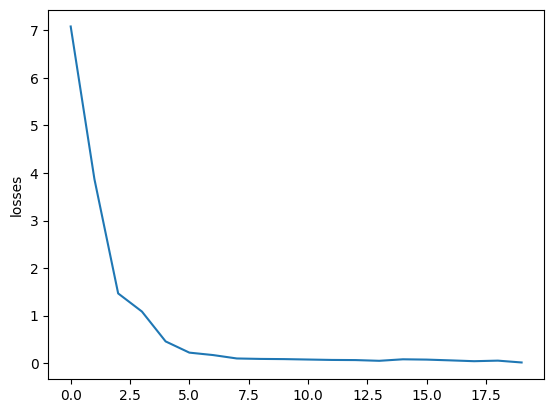

In [18]:
"""
DESCRIPTION OF ARGUMENTS:

log_every: determines how often (based on iterations) training loss should be printed
out.

val_niter: hyperparameter to determine how often evaluation on validation set
should be done (used only when you want to train on the entire corpus).

max_epoch: determines maximum number of epochs you want the model to be trained.
When you reach this number of epochs, you should break the training loop.

lr: learning rate

uniform_init: will indicate the low and high values used for uniform initialization
of the weights of the model (e.g. if it is 0.1, then initial weights would be
distributed uniformly over (-0.1, +0.1)).

debug: set it to True for sanity check and to False for training on entire
corpus.

This cell should run pretty fast on GPU. Training for 200 epochs on the first 100
samples takes roughly 10 seconds for us.
"""

args = dict(batch_size=32, embed_size=256, hidden_size=256, dropout_rate=0.0,
            uniform_init=0.1, lr=1e-3, log_every=10, max_epoch=200,
            val_niter=None, debug=True)

train(args)

### 3.6 Greedy Decode and Evaluation

Implement `greedy_decode()` method of AttnSeq2Seq. This method will generate the translation of a single sentence in the target langauge using the greedy decoding algorithm.

Test your implementation with the following function which runs greedy decoding for the model you trained and saved on the first 100 samples and prints out the sentences for which your output does not match the ground truth output. As your model has overfitted on the first 100 sentences, ALMOST all of your outputs must match the gournd truth outputs and only a couple of sentences should be printed out!

In [19]:
def evaluate_sanity():
    ################################################################################
    # TODO: 1) Load a pretrained model                                             #
    ################################################################################

    model = torch.load('model_D')

    pass
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    src_sents, tgt_sents = read_corpus(DATA_PATH)
    src_sents, tgt_sents = src_sents[:100], tgt_sents[:100]

    model.to(DEVICE)
    model.eval()
    print('\nformat of prints: [sample-index] [source-sentence] [your-translation] [ground-truth-translation]\n')
    for it, (src_sent, tgt_sent) in enumerate(zip(src_sents, tgt_sents)):
        src_sent_tensor = src_vocab.to_tensor(src_sent).unsqueeze(1)
        if ['<START>'] + model.greedy_decode(src_sent_tensor, tgt_vocab) != tgt_sent:
            print(it+1, src_sent, ['<START>'] + model.greedy_decode(src_sent=src_sent_tensor, tgt_vocab=tgt_vocab),
                  '\t', tgt_sent)

evaluate_sanity()

Reading the corpus...

format of prints: [sample-index] [source-sentence] [your-translation] [ground-truth-translation]

22 ['merci', '!'] ['<START>', 'thanks', '.', '<END>'] 	 ['<START>', 'cheers', '!', '<END>']
78 ['degage', '!'] ['<START>', 'go', 'away', '!', '<END>'] 	 ['<START>', 'beat', 'it', '.', '<END>']
88 ['allez', '!'] ['<START>', 'come', 'on', '!', '<END>'] 	 ['<START>', 'come', 'on', '.', '<END>']


After making sure that your network works fine, now let's set ```debug = False``` and train your network on the entire corpus. This time, you also need to report loss on the validation set. Before running the following cell, please pay attention to the notes mentioned in the text cell before the train loop. Don't forget to plot your results afterwards (feel free to return any values you need from the train function.)

Reading the corpus...
TRAINING ON ENTIRE CORPUS!
Begin training
Epoch num 10 mean training loss: 4.580414772033691
Epoch num 10 mean validation loss 9.131394306818644
Epoch num 20 mean training loss: 3.4611656665802
Epoch num 20 mean validation loss 8.597150802612305
Epoch num 30 mean training loss: 2.8610806465148926
Epoch num 30 mean validation loss 10.240750948588053
Epoch num 40 mean training loss: 2.4904529452323914
Epoch num 40 mean validation loss 10.725408554077148
Epoch num 50 mean training loss: 2.220949578285217
Epoch num 50 mean validation loss 12.157597064971924
Epoch num 60 mean training loss: 2.0211597879727683
Epoch num 60 mean validation loss 12.103623549143473
Epoch num 70 mean training loss: 1.8663606473377772
Epoch num 70 mean validation loss 12.757867177327475
Epoch num 80 mean training loss: 1.7626219540834427
Epoch num 80 mean validation loss 12.241875330607096
Epoch num 90 mean training loss: 1.6549915671348572
Epoch num 90 mean validation loss 13.24269835154215

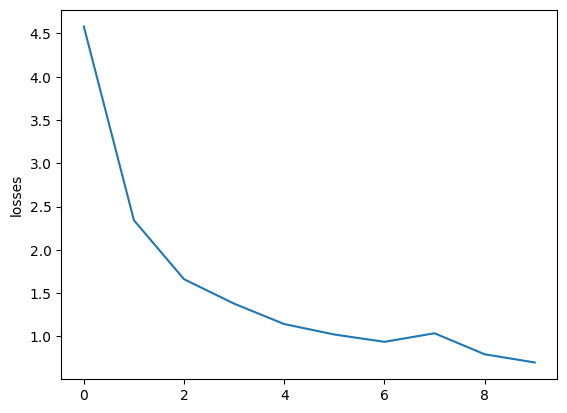

In [20]:
args = dict(batch_size=256, embed_size=256, hidden_size=256, dropout_rate=0.2,
            uniform_init=0.1, lr=1e-3, log_every=10, max_epoch=100,
            val_niter=10, debug=False)

train(args)

Now let's use your trained model to generate translations of a random sample of validation sentences in the dataset:

In [21]:
def evaluate():
    ################################################################################
    # TODO: 1) Load a model pretrained on the entire corpus                        #
    ################################################################################
    model = torch.load('model')
    pass
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    model.to(DEVICE)
    model.eval()

    set_seed(40719)
    src_sents, tgt_sents = read_corpus(DATA_PATH)
    val_ratio = 0.01
    val_size = int(len(src_sents) * val_ratio)
    train_size = len(src_sents) - val_size

    _, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    print('\nformat of prints: [source-sentence] [your-translation] [ground-truth-translation]\n')

    idxs = np.random.randint(0, len(val_dataset), 50)

    for idx in idxs:
        src_sent_tensor, tgt_sent_tensor = val_dataset[idx]['src'], val_dataset[idx]['tgt']
        src_sent = [src_vocab.get_token_by_id(el.item()) for el in src_sent_tensor]
        tgt_sent = [tgt_vocab.get_token_by_id(el.item()) for el in tgt_sent_tensor]
        print('source sentence:\n\t', src_sent)
        print('Your translation:\n\t', ['<START>'] + model.greedy_decode(src_sent_tensor.unsqueeze(1), tgt_vocab))
        print('Ground truth translation:\n\t', tgt_sent, '\n\n')

evaluate()

Reading the corpus...

format of prints: [source-sentence] [your-translation] [ground-truth-translation]

source sentence:
	 ['que', 'dites', 'vous', 'd', 'aller', 'voir', 'un', 'film', 'ce', 'soir', '?']
Your translation:
	 ['<START>', 'how', 'about', 'eating', 'see', 'a', 'movie', 'tonight', '?', '<END>']
Ground truth translation:
	 ['<START>', 'how', 'about', 'going', 'to', 'see', 'a', 'movie', 'tonight', '?', '<END>'] 


source sentence:
	 ['c', 'est', 'tout', 'ce', 'que', 'nous', 'faisons', 'ici', '.']
Your translation:
	 ['<START>', 'that', 's', 'all', 'we', 'do', 'here', '.', '<END>']
Ground truth translation:
	 ['<START>', 'that', 's', 'all', 'we', 'do', 'here', '.', '<END>'] 


source sentence:
	 ['elle', 'passe', 'tout', 'son', 'temps', 'a', 'penser', 'aux', 'garcons', '.']
Your translation:
	 ['<START>', 'she', 'spends', 'all', 'at', 'doing', 'anything', 'time', 'thinking', 'about', 'boys', '.', '<END>']
Ground truth translation:
	 ['<START>', 'she', 'spends', 'all', 'her', 

**Note**: If you have implemented everything right, You should see that your network generates some of the translations correctly, some of its outputs mismatch in only a couple of words with the ground truth output, and some of them are even worse than that! <br/>
You will witness that sometimes your network repeats generating a single word consecutively for multiple time steps and then after that the translation goes completely in the wrong way! In fact, these are all drawbacks of greedy decoding algorithm. As the network gets its own output, once one output is wrong, the network gets lost and can can generate garbage translation afterwards! There is an algorithm called **beam search** which amis to fix this issue and can generate much better outputs. But, it is outside the scope of our class. Interested students can search and read more about this algorithm on the Internet.

**One final point**: Note that there are some advanced packages out there such as, spaCy and torchtext, that can help you automate many of the tasks we did above manullay (e.g. preprocessing, masking, reading the sequences, and etc.). Now that you have learned what's under the hood of training a Seq2Seq model, you can use these packages to make developing your Seq2Seq model easier from this point onwards!

### 3.7 Submission

- Check and review your answers. Make sure all cells' output are what you have planned.
- Select File > Save.
- To download the notebook, select File > Download .ipynb.
- Create an archive of all notebooks (P1.ipynb, P2.ipynb, and P3.ipynb)

### 3.8 References

[1] Minh-Thang Luong, Hieu Pham, Christopher D. Manning, "Effective Approaches to Attention-based Neural Machine Translation", CoRR 2015 https://arxiv.org/abs/1508.04025.

[2] PyTorch Sequence to Sequence Machine Translation Tutorial https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

[3] CS224N, Stanford University, Assignment 4

[4] https://colab.research.google.com/drive/1uFJBO1pgsiFwCGIJwZlhUzaJ2srDbtw-